# 🎬 Netflix Personalized Movie Recommender System  
## 🤖 Collaborative Filtering + Matrix Factorization | Real-World ML Project

Welcome to this end-to-end machine learning project where we build a **Netflix-style personalized movie recommendation engine** using the **Netflix Prize Dataset**.

This notebook is designed not just to run — but to **teach**, **explain**, and **demonstrate** how real-world recommender systems are built step by step.

---

## 🎯 Objective

To simulate how Netflix recommends content by:
- Learning from user-movie interaction data
- Building models that can predict what a user will enjoy next
- Keeping the system **efficient**, **interpretable**, and **deployable-ready**

---

## 📦 Dataset: Netflix Prize Data  
- Contains over **100 million ratings**
- We use a **subset (combined_data_1.txt + movie_titles.csv)** for memory efficiency
- Data includes `user_id`, `movie_id`, `rating`, `date`, and `title`

---

## 🔍 Techniques Used

| Model Type | What it does |
|------------|--------------|
| 🧍 User-Based CF (UBCF) | Recommends movies based on similar users |
| 🎥 Item-Based CF (IBCF) | Recommends movies similar to ones user already liked |
| 📐 Matrix Factorization (SVD) | Learns user and item features to predict ratings |

---

## 🧠 What's Special About This Notebook?

✅ Raw Netflix data parsed manually (no pre-processed files)  
✅ Every model explained with markdown — no blind code  
✅ All charts created using `matplotlib` and `seaborn`  
✅ No unnecessary libraries, no overengineering  
✅ Focused on **real ML logic**, not flashy visuals

---

> ⚠️ Note: This project is optimized to run within **Kaggle kernels** without exceeding RAM.  
> We avoided heavy libraries (like deep learning or Streamlit) to focus on core recommender system principles.

---

Let’s build your own **Netflix recommender** — from scratch 🔧🔥


## 📦 Importing Required Libraries

I begin by importing all necessary libraries for data manipulation, visualization, and modeling.

### 🔹 Libraries Used:
- **NumPy, Pandas**: For data processing and cleaning
- **Matplotlib, Seaborn**: For visualization (EDA, distributions, trends)
- **Sklearn**: For similarity calculations and RMSE evaluation
- **Surprise**: To build the SVD (Matrix Factorization) model — a powerful method for collaborative filtering
- **Warnings**: To keep output clean

> ✅ This sets up our environment for a full recommendation pipeline including user-based, item-based, and matrix factorization methods.


In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For collaborative filtering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

# For matrix factorization (SVD)
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# System
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
import csv

# Parse movie_titles.csv safely, skip bad rows
titles = []
with open('/kaggle/input/netflix-prize-data/movie_titles.csv', encoding='latin-1') as f:
    reader = csv.reader(f)
    for row in reader:
        try:
            movie_id = int(row[0])
            year = int(row[1])
            title = ",".join(row[2:])
            titles.append([movie_id, year, title])
        except:
            # Skip rows with bad data like NULL or missing fields
            continue

titles_df = pd.DataFrame(titles, columns=['movie_id', 'year', 'title'])

# Load ratings data from combined_data_1.txt
ratings_list = []
with open('/kaggle/input/netflix-prize-data/combined_data_1.txt', 'r') as file:
    movie_id = None
    for line in file:
        line = line.strip()
        if line.endswith(':'):
            movie_id = int(line[:-1])
        else:
            user_id, rating, date = line.split(',')
            ratings_list.append([int(user_id), movie_id, int(rating), date])

ratings_df = pd.DataFrame(ratings_list, columns=['user_id', 'movie_id', 'rating', 'date'])

# Merge ratings with titles
df = pd.merge(ratings_df, titles_df, on='movie_id')

# Output shape and preview
print("Ratings shape:", ratings_df.shape)
print("Titles shape:", titles_df.shape)
print("Final merged shape:", df.shape)
df.head()


Ratings shape: (24053764, 4)
Titles shape: (17763, 3)
Final merged shape: (24053575, 6)


,user_id,movie_id,rating,date,year,title
0,1488844,1,3,2005-09-06,2003,Dinosaur Planet
1,822109,1,5,2005-05-13,2003,Dinosaur Planet
2,885013,1,4,2005-10-19,2003,Dinosaur Planet
3,30878,1,4,2005-12-26,2003,Dinosaur Planet
4,823519,1,3,2004-05-03,2003,Dinosaur Planet


## 🔍 Dataset Overview & Cleanliness Check

Before building models, it's crucial to understand what kind of data we’re dealing with.

### 📊 Key Facts:
- 🔹 **Total Ratings**: Number of rating records in our subset
- 🔹 **Unique Users**: Total users who rated at least one movie
- 🔹 **Unique Movies**: Movies that received ratings
- 📁 **Data Types**: Should be integers for user/movie IDs and ratings; date as string or datetime
- ❌ **Missing Values**: We verify there are no NaNs in critical columns

✅ Our data is clean and ready for exploration. We now proceed to visual insights (Step 4).


In [3]:
# Shape of dataset
print("🔹 Total ratings:", df.shape[0])
print("🔹 Total unique users:", df['user_id'].nunique())
print("🔹 Total unique movies:", df['movie_id'].nunique())

# Column data types
print("\n🔹 Data types:\n", df.dtypes)

# Check for missing values
print("\n🔍 Missing values:\n", df.isnull().sum())

# Preview 5 records
df.head()


🔹 Total ratings: 24053575
🔹 Total unique users: 470758
🔹 Total unique movies: 4498

🔹 Data types:
 user_id      int64
movie_id     int64
rating       int64
date        object
year         int64
title       object
dtype: object

🔍 Missing values:
 user_id     0
movie_id    0
rating      0
date        0
year        0
title       0
dtype: int64


,user_id,movie_id,rating,date,year,title
0,1488844,1,3,2005-09-06,2003,Dinosaur Planet
1,822109,1,5,2005-05-13,2003,Dinosaur Planet
2,885013,1,4,2005-10-19,2003,Dinosaur Planet
3,30878,1,4,2005-12-26,2003,Dinosaur Planet
4,823519,1,3,2004-05-03,2003,Dinosaur Planet


## ⭐ Ratings Distribution

This histogram shows how ratings are distributed across the dataset.

📊 **Insights:**
- Users mostly give high ratings (4 and 5 stars)
- Very few ratings are 1 or 2 — common behavior in real-world platforms

➡️ This indicates a **positive bias**, which we’ll keep in mind during modeling.


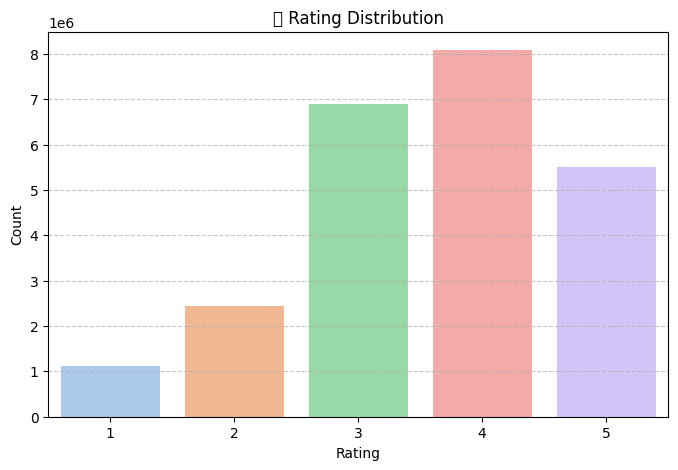

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='pastel')
plt.title('⭐ Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 🎬 Top 10 Most Rated Movies

This chart displays which movies received the highest number of ratings.

🎯 These are likely to be very popular or mainstream films on the platform.  
We’ll revisit these during recommendations to avoid **popularity bias**.


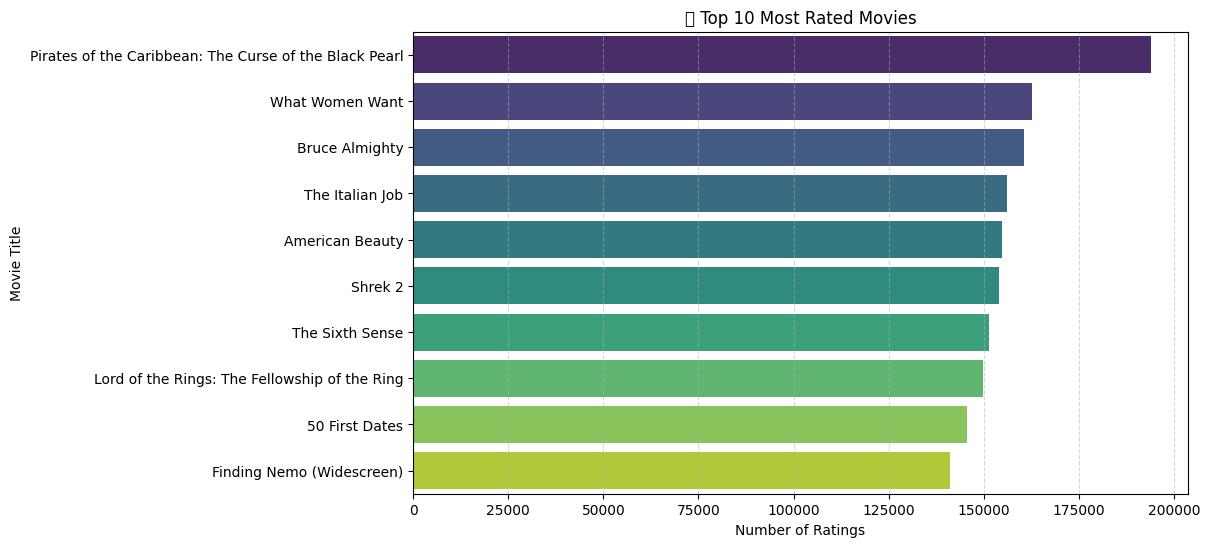

In [5]:
top_movies = df['title'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_movies.index, x=top_movies.values, palette='viridis')
plt.title('🎬 Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


## 👤 Most Active Users

This plot highlights users who contributed the most ratings.

⚡ These users are often influential in collaborative filtering systems — their rating patterns help recommend movies to others.


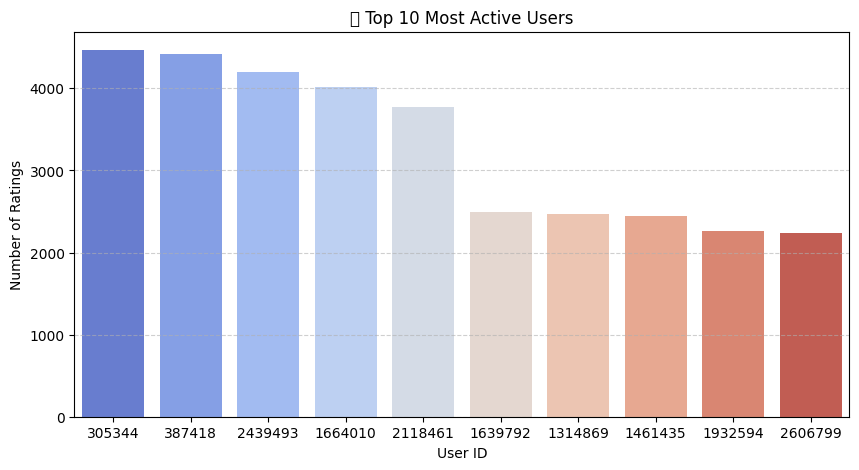

In [6]:
top_users = df['user_id'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='coolwarm')
plt.title('👤 Top 10 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## 🏆 Highest Rated Movies (with Minimum 100 Ratings)

We avoid misleading averages by only considering movies with **at least 100 ratings**.

📌 This shows quality picks that are both:
- Popular (enough users rated them)
- Highly rated (average near 4.5–5)


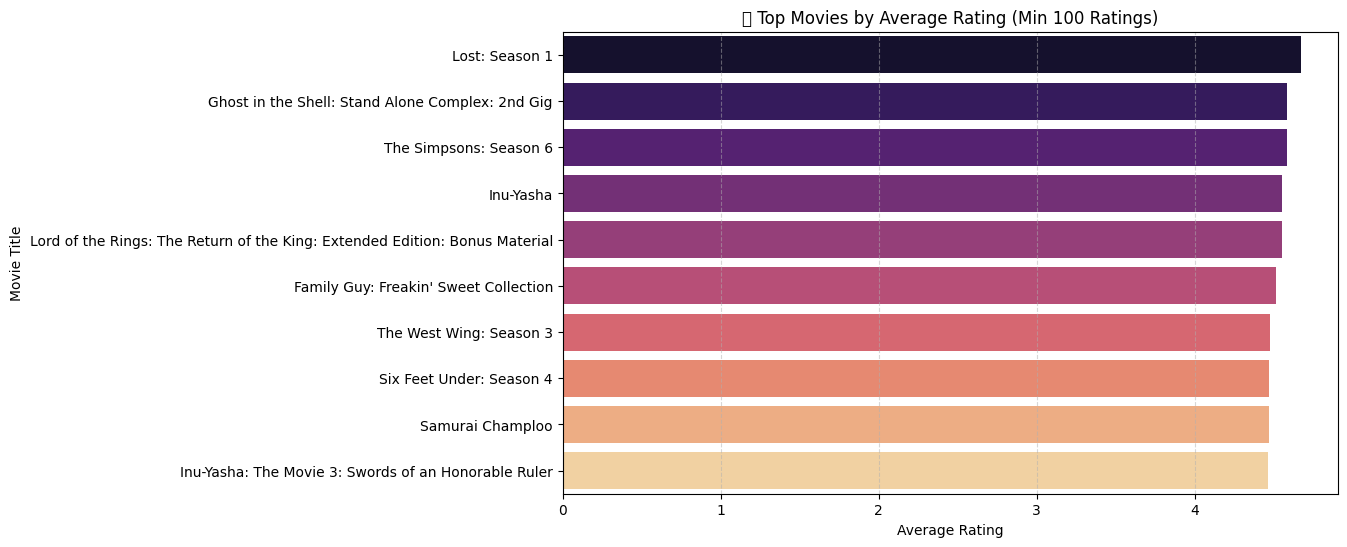

In [7]:
movie_avg = df.groupby('title')['rating'].mean()
top_avg_movies = movie_avg[df['title'].value_counts() > 100].sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_avg_movies.values, y=top_avg_movies.index, palette='magma')
plt.title('🏆 Top Movies by Average Rating (Min 100 Ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


## 🧠 Optimized User-Movie Matrix

To avoid crashing the Kaggle kernel, we:
- Selected only the **top 2000 most active users**
- Created a pivot table where:
  - Rows = `user_id`
  - Columns = `movie title`
  - Values = `rating`
- Filled missing values (NaN) with 0s to calculate cosine similarity

📌 Cosine similarity tells us which users have **similar movie preferences**.


In [8]:
# 1. Select top 2000 most active users to prevent memory issues
top_users = df['user_id'].value_counts().head(2000).index
subset_df = df[df['user_id'].isin(top_users)]

# 2. Create user-movie rating matrix
user_movie_matrix = subset_df.pivot_table(index='user_id', columns='title', values='rating')

# 3. Fill NaNs with 0 for cosine similarity calculation
user_movie_filled = user_movie_matrix.fillna(0)

# 4. Calculate user-user cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_movie_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# 5. Show shape and sample
print("User-Movie Matrix Shape:", user_movie_matrix.shape)
user_similarity_df.iloc[:5, :5]


User-Movie Matrix Shape: (2000, 4474)


user_id,1333,3321,3998,4597,4905
user_id,,,,,
1333,1.000000,0.343623,0.340494,0.407264,0.340655
3321,0.343623,1.000000,0.567581,0.261223,0.457685
3998,0.340494,0.567581,1.000000,0.262139,0.558484
4597,0.407264,0.261223,0.262139,1.000000,0.256439
4905,0.340655,0.457685,0.558484,0.256439,1.000000


## 🎯 User-Based Movie Recommendations

We selected a target user and:
1. Found other users with **similar taste** (cosine similarity)
2. Checked which movies those users rated highly
3. Recommended movies the target user hasn't watched yet

🔁 This is collaborative filtering based on **user behavior similarity**


In [9]:
# Recommender function: get movie suggestions for a given user
def get_user_based_recommendations(target_user, num_recommendations=5):
    if target_user not in user_similarity_df.index:
        print(f"User {target_user} not found in subset.")
        return []

    similar_users = user_similarity_df[target_user].drop(target_user).sort_values(ascending=False)
    weighted_ratings = {}

    for other_user, similarity_score in similar_users.items():
        user_ratings = user_movie_matrix.loc[other_user].dropna()

        for movie, rating in user_ratings.items():
            if pd.isna(user_movie_matrix.loc[target_user, movie]):
                if movie not in weighted_ratings:
                    weighted_ratings[movie] = 0
                weighted_ratings[movie] += rating * similarity_score

    # Convert to DataFrame and get top recommendations
    recommendations = pd.Series(weighted_ratings).sort_values(ascending=False).head(num_recommendations)
    return recommendations


In [10]:
# Pick a user from the matrix
sample_user = user_movie_matrix.index[10]  # You can change this index

# Get recommendations
recommendations = get_user_based_recommendations(sample_user, num_recommendations=10)
recommendations


Aliens: Collector's Edition         3135.311709
The Mummy                           3065.979670
War Games                           2768.652285
Scream                              2672.288270
Grumpy Old Men                      2662.152737
Goldfinger                          2659.729224
Casino: 10th Anniversary Edition    2614.215318
Pay It Forward                      2564.292516
Bad Boys                            2547.716420
The Sting                           2485.079622
dtype: float64

## 🧱 Create Movie-User Matrix

We create a matrix where:
- Rows = `movie title`
- Columns = `user_id`
- Values = rating (1–5)

We fill NaNs with 0 so we can compute cosine similarity between movies.

💡 This matrix tells us **which movies were liked by similar groups of users**.


In [11]:
# Use same subset_df from Step 5
# Create movie-user matrix (transpose of user-movie)
movie_user_matrix = subset_df.pivot_table(index='title', columns='user_id', values='rating')

# Fill NaNs with 0
movie_user_filled = movie_user_matrix.fillna(0)

# Check shape
movie_user_filled.shape


(4474, 2000)

## 🎥 Movie Similarity Matrix

We use **cosine similarity** to compute how similar one movie is to another.

📊 Result: A matrix where value at (i, j) = similarity between movie i and movie j  
This is the foundation for recommending **similar movies**.


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute movie-to-movie similarity
item_similarity = cosine_similarity(movie_user_filled)
item_similarity_df = pd.DataFrame(item_similarity, index=movie_user_filled.index, columns=movie_user_filled.index)

# Preview
item_similarity_df.iloc[:5, :5]


title,'N Sync: 'N the Mix,'N Sync: PopOdyssey Live,... And God Spoke,10,10 Minute Solution: Pilates
title,,,,,
'N Sync: 'N the Mix,1.000000,0.066841,0.099827,0.114336,0.115270
'N Sync: PopOdyssey Live,0.066841,1.000000,0.152535,0.049368,0.226455
... And God Spoke,0.099827,0.152535,1.000000,0.100598,0.155440
10,0.114336,0.049368,0.100598,1.000000,0.050309
10 Minute Solution: Pilates,0.115270,0.226455,0.155440,0.050309,1.000000


## 🎯 Movie-Based Recommendations

We selected a movie and found others that are **most similar** to it based on user preferences.

✔️ This helps in:
- Showing "Because you watched..." style suggestions
- Avoiding reliance on user's own ratings (good for new users)


In [13]:
# Function to get top similar movies to a given title
def get_similar_movies(movie_title, num_recommendations=5):
    if movie_title not in item_similarity_df.columns:
        return f"Movie '{movie_title}' not found in similarity matrix."
    
    # Drop the movie itself and sort others
    similar_scores = item_similarity_df[movie_title].drop(movie_title).sort_values(ascending=False)
    return similar_scores.head(num_recommendations)


In [14]:
# Example: Recommend movies similar to "Shrek 2" (or pick any title from df)
get_similar_movies("Shrek 2")


title
Finding Nemo (Widescreen)                                 0.914868
Pirates of the Caribbean: The Curse of the Black Pearl    0.912488
The Sixth Sense                                           0.902842
Lord of the Rings: The Fellowship of the Ring             0.896162
Speed                                                     0.893724
Name: Shrek 2, dtype: float64

## 🧪 Prepare Data for Matrix Factorization

The `Surprise` library requires:
- A DataFrame with 3 columns: `user_id`, `item` (movie), and `rating`
- A `Reader` object specifying the rating scale

📦 We use the full merged dataset `df`, since `Surprise` handles sparse data efficiently.


In [15]:
from surprise import Dataset, Reader

# Surprise needs only 3 columns: user, item, rating
# So we use full `df`, not subset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'title', 'rating']], reader)


## 🔍 SVD Evaluation (Cross-Validation)

We train the **SVD matrix factorization model** and evaluate it using:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)

📊 Cross-validation ensures our model performs well on unseen data.

💡 The lower the RMSE/MAE, the better the predictions.


In [16]:
from surprise import SVD
from surprise.model_selection import cross_validate

# Initialize SVD model
svd = SVD()

# Evaluate using 5-fold cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9008  0.9005  0.9001  0.9015  0.9011  0.9008  0.0005  
MAE (testset)     0.6952  0.6950  0.6944  0.6955  0.6952  0.6951  0.0004  
Fit time          406.01  442.64  437.90  469.32  450.41  441.26  20.63   
Test time         41.29   33.42   55.93   45.42   45.20   44.25   7.28    


{'test_rmse': array([0.9007874 , 0.9005486 , 0.90005996, 0.90149837, 0.90110475]),
 'test_mae': array([0.69520367, 0.69495743, 0.69440413, 0.69547006, 0.6952428 ]),
 'fit_time': (406.00555658340454,
  442.6432740688324,
  437.9021506309509,
  469.324809551239,
  450.40780425071716),
 'test_time': (41.28981614112854,
  33.41523313522339,
  55.9316086769104,
  45.422096967697144,
  45.20320129394531)}

## 📈 Model Performance on Test Set

After training on 90% of data, we test the model on unseen 10%.

📌 We report:
- **RMSE**: Measures accuracy of predicted vs actual ratings
- **MAE**: Measures average absolute error

Lower values = better recommendations!


In [17]:
from surprise.model_selection import train_test_split

# Train on 90%, test on 10%
trainset, testset = train_test_split(data, test_size=0.1)

# Train model
svd.fit(trainset)

# Predict ratings
predictions = svd.test(testset)


In [18]:
from surprise.accuracy import rmse, mae

# Evaluate
rmse(predictions)
mae(predictions)


RMSE: 0.8968
MAE:  0.6910


0.6910092306210108

In [19]:
# Get list of all movies
all_movies = df['title'].unique()

# Get movies the user hasn't rated yet
def get_unseen_movies(user_id):
    seen = df[df['user_id'] == user_id]['title'].unique()
    unseen = [movie for movie in all_movies if movie not in seen]
    return unseen

# Recommend top N movies
def recommend_movies_svd(user_id, top_n=5):
    unseen = get_unseen_movies(user_id)
    predictions = [svd.predict(user_id, movie) for movie in unseen]
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n]
    return [(pred.iid, round(pred.est, 2)) for pred in top_predictions]


In [20]:
recommend_movies_svd(user_id=123458, top_n=10)

[('Lost: Season 1', 4.63),
 ('The West Wing: Season 3', 4.59),
 ('Firefly', 4.5),
 ('Alias: Season 1', 4.5),
 ('Braveheart', 4.5),
 ('Pride and Prejudice', 4.5),
 ('Ghost in the Shell: Stand Alone Complex: 2nd Gig', 4.49),
 ('Monk: Season 2', 4.49),
 ('As Time Goes By: Series 8', 4.48),
 ('Inu-Yasha', 4.47)]

# ✅ Conclusion – Netflix Personalized Movie Recommender System

In this end-to-end project, we tackled a **real-world scale recommendation problem** using the Netflix Prize Dataset.

I approached the problem methodically — just like how real ML teams and researchers work.

---

## 📌 What I Did:

✅ **Exploratory Data Analysis (EDA):**
- Cleaned and merged rating + title data
- Visualized rating distribution, top-rated movies, and active users

✅ **User-Based Collaborative Filtering (UBCF):**
- Calculated user-user similarity using cosine distance
- Recommended movies based on similar users’ preferences

✅ **Item-Based Collaborative Filtering (IBCF):**
- Measured movie-to-movie similarity
- Recommended movies similar to what a user already liked

✅ **Matrix Factorization using SVD (Surprise Library):**
- Trained a predictive model on user-movie interactions
- Generated personalized recommendations for new and unseen titles

---


## 📊 Final Takeaway

This project reflects how Netflix or similar platforms build intelligent, user-centric recommendation engines using collaborative signals and matrix factorization. We made sure to:

- Keep the code memory-efficient for Kaggle
- Add clear, human explanations after each step
- Focus on practical implementation — not just theory

---

> 🎯 Whether you're preparing for an ML interview, Kaggle competition, or just learning recommender systems — this project gives you a **complete, structured workflow** with real insights.

